## 1. Explore the dataset

### 1.1 Deal with missing values

In [100]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
BJ=pd.read_csv('/Users/jiaxinteng/Academic/FDS/project/FiveCitiePMData/BeijingPM20100101_20151231.csv')
#BJ.cbwd.value_counts()
#BJ.cbwd.nunique()

# drop the features that won't be used
BJ=BJ.drop(['No','PM_Dongsi','PM_Dongsihuan','PM_Nongzhanguan','Iprec','cbwd'],axis=1)
print(BJ.isnull().sum())
BJ[21:25]

year                0
month               0
day                 0
hour                0
season              0
PM_US Post       2197
DEWP                5
HUMI              339
PRES              339
TEMP                5
Iws                 5
precipitation     484
dtype: int64


,year,month,day,hour,season,PM_US Post,DEWP,HUMI,PRES,TEMP,Iws,precipitation
21,2010,1,1,21,4,NaN,-17.0,38.0,1018.0,-5.0,1.79,0.0
22,2010,1,1,22,4,NaN,-17.0,38.0,1018.0,-5.0,2.68,0.0
23,2010,1,1,23,4,129.0,-17.0,41.0,1020.0,-5.0,0.89,0.0
24,2010,1,2,0,4,148.0,-16.0,38.0,1020.0,-4.0,1.79,0.0


In [2]:
# drop NA in feature variables
BJ_new = BJ[pd.notnull(BJ['DEWP'])]
BJ_new = BJ_new[pd.notnull(BJ_new['HUMI'])]
BJ_new = BJ_new[pd.notnull(BJ_new['precipitation'])]
BJ_new.isnull().sum()

year                0
month               0
day                 0
hour                0
season              0
PM_US Post       2186
DEWP                0
HUMI                0
PRES                0
TEMP                0
Iws                 0
precipitation       0
dtype: int64

### 1.2 Assign label to training and validation set

In [3]:
# look into the characteristic of PM density data
BJ_new['PM_US Post'].describe()

count    49579.000000
mean        95.831703
std         91.801976
min          1.000000
25%         27.000000
50%         69.000000
75%        132.000000
max        994.000000
Name: PM_US Post, dtype: float64

##### The average of the PM 2.5 density is 95.9 $\mu g/m^3$, the maximum is 994 $\mu g/m^3$ and the minimum is 1 $\mu g/m^3$. The difference is large and it's interesting to see at what time the density can be such high and low. We plan to categorize the PM 2.5 desity into 10 groups. And build a prediction model using the given meteorological features. Finally use the model to predict the missing PM density in the time series.

In [4]:
# take the rows with unknown PM density as test set, the rest are used as training and validation
BJ_tst=BJ_new[BJ_new['PM_US Post'].isnull()]
BJ_trv=BJ_new[~BJ_new['PM_US Post'].isnull()]

In [5]:
# group the PM values (label the training and validation data)
a=BJ_trv['PM_US Post'].values//100+1
#print(a)
#print(len(a))
BJ_trv=BJ_trv.assign(pm_group = a)
BJ_trv.pm_group=BJ_trv.pm_group.astype(int)

# how many groups?
BJ_trv['pm_group'].value_counts()

1     31900
2     11656
3      3969
4      1398
5       486
6       123
7        28
9         8
8         8
10        3
Name: pm_group, dtype: int64

##### There are 10 groups in our dataset, but most cases are in group 1 and group 2.

In [6]:
# drop time related features and PM values
BJ_trv=BJ_trv.drop(['year','month','day','hour','PM_US Post'],1)
BJ_tst=BJ_tst.drop(['year','month','day','hour'],1)

In [7]:
BJ_trv.head(5)
#BJ_tst.head(5)

,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,pm_group
23,4,-17.0,41.0,1020.0,-5.0,0.89,0.0,2
24,4,-16.0,38.0,1020.0,-4.0,1.79,0.0,2
25,4,-15.0,42.0,1020.0,-4.0,2.68,0.0,2
26,4,-11.0,63.5,1021.0,-5.0,3.57,0.0,2
27,4,-7.0,85.0,1022.0,-5.0,5.36,0.0,2


## 2. Correlation analysis

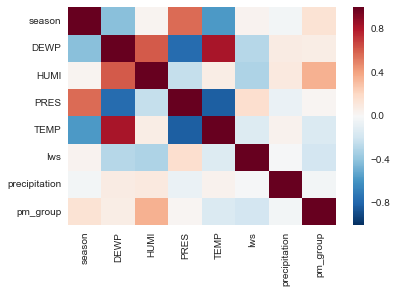

                 season      DEWP      HUMI      PRES      TEMP       Iws  \
season         1.000000 -0.417331  0.029564  0.564618 -0.572560  0.036741   
DEWP          -0.417331  1.000000  0.612170 -0.772658  0.821416 -0.286537   
HUMI           0.029564  0.612170  1.000000 -0.234500  0.077836 -0.306823   
PRES           0.564618 -0.772658 -0.234500  1.000000 -0.825144  0.168600   
TEMP          -0.572560  0.821416  0.077836 -0.825144  1.000000 -0.140524   
Iws            0.036741 -0.286537 -0.306823  0.168600 -0.140524  1.000000   
precipitation -0.023714  0.083202  0.097002 -0.064131  0.045718 -0.013590   
pm_group       0.146812  0.076745  0.357067  0.015882 -0.147023 -0.182002   

               precipitation  pm_group  
season             -0.023714  0.146812  
DEWP                0.083202  0.076745  
HUMI                0.097002  0.357067  
PRES               -0.064131  0.015882  
TEMP                0.045718 -0.147023  
Iws                -0.013590 -0.182002  
precipitation      

In [8]:
# correlation between each features and target variables
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
cor=BJ_trv.corr()
sns.heatmap(cor, xticklabels=cor.columns.values, yticklabels=cor.columns.values)
plt.show()
print(cor)

##### A summary from the correlation matrix: From the correlation matrix, we can see the PM density has relatively strong relationship with humidity and Iws (Cumulated wind speed). 

## 3. Prepare the dataset and train a prediction model

### 3.1 Decision tree

In [9]:
# divide BJ_tsv into training and validation
import random
l=len(BJ_trv.index)
train_index = random.sample(range(l),round(0.8*l))  # find the training data set index
# print(train_index)
train_df = BJ_trv.iloc[train_index]
val_df = BJ_trv[~BJ_trv.index.isin(train_index)]

In [10]:
# Build a decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
clf = DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(train_df.drop('pm_group',axis=1),train_df.pm_group)

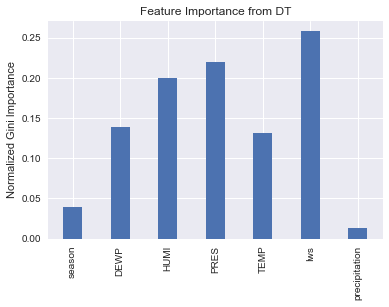

In [11]:
# feature importance
import numpy as np
fig, ax = plt.subplots()
ax.bar(np.arange(7), clf.feature_importances_,0.4)
ax.set_xticks(np.arange(len(clf.feature_importances_)))
ax.set_xticklabels(train_df.drop('pm_group',axis=1).columns.values,rotation=90)
plt.title('Feature Importance from DT')
ax.set_ylabel('Normalized Gini Importance')

In [12]:
# evaluate the tree model
val_pred=clf.predict(val_df.drop('pm_group',1))
clf.score(val_df.drop('pm_group',1),val_df.pm_group)

0.90564924114671164

### 3.2 Logistic regression

In [13]:
#from sklearn import linear_model
#logreg=linear_model.LogisticRegression(C=1e5,solver='sag')
#logreg.fit(train_df.drop('pm_group', axis=1),train_df.pm_group) 
#val_pred_log=logreg.predict(val_df.drop('pm_group',1))
#logreg.score(val_df.drop('pm_group',1),val_df.pm_group)
#np.unique(val_pred_log)

### 3.3 SVM

In [14]:
#from sklearn.svm import SVC
#svm_clf=SVC(kernel='linear',C=1e10)
#svm_clf.fit(train_df.drop('pm_group', axis=1),train_df.pm_group)  
#val_pred_sv=svm_clf.predict(val_df.drop('pm_group',1))
#svm_clf.score(val_df.drop('pm_group',1),val_df.pm_group)

### 3.4 KNN

In [15]:
#from sklearn.neighbors import KNeighborsClassifier

#neigh = KNeighborsClassifier(n_neighbors=1)
#neigh.fit(train_df.drop('pm_group', axis=1),train_df.pm_group)
#val_pred_knn = neigh.predict(val_df.drop('pm_group',1))
#knn_score = neigh.score(val_df.drop('pm_group',1),val_df.pm_group)
#print(knn_score)

##### It is interesting to see that the logistic regression has very low accuracy comparing to the results given by decision tree, also it takes very long time to build a support vector machine model. The nonlinearities exists in the dataset may account for this observation. From another perspective, the decision tree model has the ability to handle nonlinearity inherently.

## 4. Predict the missing values using Decision Tree Model

In [16]:
val_fil=clf.predict(BJ_tst.drop('PM_US Post',1))
val_est=val_fil*100-50
BJ_tst['PM_US Post']=val_est
#BJ_tst['PM_US Post'].value_counts()
BJ_tst.head(10)

,season,PM_US Post,DEWP,HUMI,PRES,TEMP,Iws,precipitation
0,4,150,-21.0,43.0,1021.0,-11.0,1.79,0.0
1,4,50,-21.0,47.0,1020.0,-12.0,4.92,0.0
2,4,50,-21.0,43.0,1019.0,-11.0,6.71,0.0
3,4,150,-21.0,55.0,1019.0,-14.0,9.84,0.0
4,4,150,-20.0,51.0,1018.0,-12.0,12.97,0.0
5,4,150,-19.0,47.0,1017.0,-10.0,16.10,0.0
6,4,150,-19.0,44.0,1017.0,-9.0,19.23,0.0
7,4,150,-19.0,44.0,1017.0,-9.0,21.02,0.0
8,4,150,-19.0,44.0,1017.0,-9.0,24.15,0.0
9,4,50,-20.0,37.0,1017.0,-8.0,27.28,0.0


In [17]:
# insert the estimated pm values into the original dataframe: BJ_new
for i in BJ_new.index:
    if(BJ_new['PM_US Post'].isnull()[i]== True):
        BJ_new.loc[i,'PM_US Post']=BJ_tst.loc[i,'PM_US Post']
BJ_new.head(10)

,year,month,day,hour,season,PM_US Post,DEWP,HUMI,PRES,TEMP,Iws,precipitation
0,2010,1,1,0,4,150.0,-21.0,43.0,1021.0,-11.0,1.79,0.0
1,2010,1,1,1,4,50.0,-21.0,47.0,1020.0,-12.0,4.92,0.0
2,2010,1,1,2,4,50.0,-21.0,43.0,1019.0,-11.0,6.71,0.0
3,2010,1,1,3,4,150.0,-21.0,55.0,1019.0,-14.0,9.84,0.0
4,2010,1,1,4,4,150.0,-20.0,51.0,1018.0,-12.0,12.97,0.0
5,2010,1,1,5,4,150.0,-19.0,47.0,1017.0,-10.0,16.10,0.0
6,2010,1,1,6,4,150.0,-19.0,44.0,1017.0,-9.0,19.23,0.0
7,2010,1,1,7,4,150.0,-19.0,44.0,1017.0,-9.0,21.02,0.0
8,2010,1,1,8,4,150.0,-19.0,44.0,1017.0,-9.0,24.15,0.0
9,2010,1,1,9,4,50.0,-20.0,37.0,1017.0,-8.0,27.28,0.0


## 5. Time series analysis

In [18]:
pm_time=pd.to_datetime(BJ_new[['year','month','day','hour']])
#dft=pd.concat([pm_time,BJ_new],axis=1)
dft=pd.DataFrame(data={'Datetime': pm_time, 'PM_density': BJ_new['PM_US Post'].values})
dft.set_index('Datetime',inplace=True)
dft.index.name=None
print(dft[-10:])

                     PM_density
2015-12-31 14:00:00        48.0
2015-12-31 15:00:00        58.0
2015-12-31 16:00:00        69.0
2015-12-31 17:00:00        91.0
2015-12-31 18:00:00       114.0
2015-12-31 19:00:00       133.0
2015-12-31 20:00:00       169.0
2015-12-31 21:00:00       203.0
2015-12-31 22:00:00       212.0
2015-12-31 23:00:00       235.0


In [101]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller

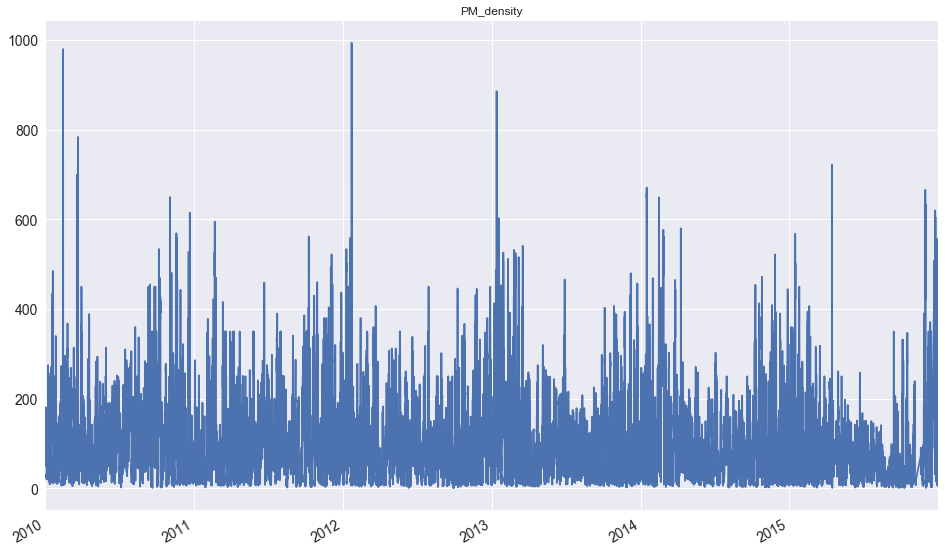

In [20]:
# plot the time series
dft.PM_density.plot(figsize=(16,10), title= 'PM_density', fontsize=14)

##### It is not surprising to see that after Nov. 2011 (the time people started learning about PM2.5), the maximum PM2.5 density is reduced. This probably resulted from the control action that Chinese government took to improve the air condition.

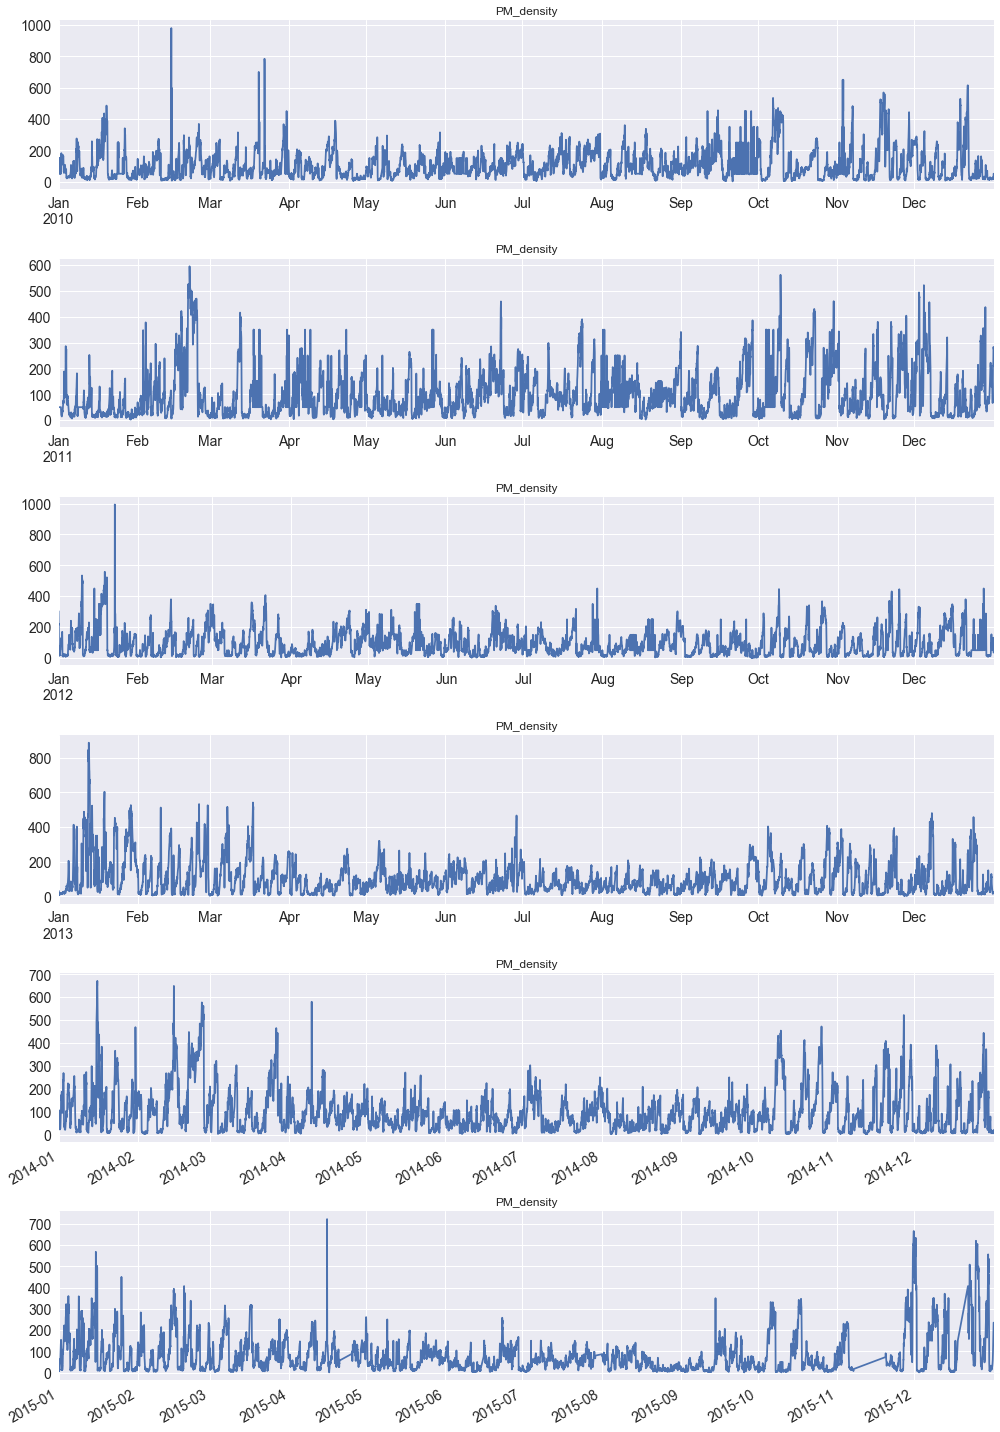

In [21]:
# visualize year by year
fig = plt.figure()
ax1 = plt.subplot(611)
fig = dft.PM_density['2010'].plot(figsize=(14,20), title= 'PM_density', fontsize=14)
ax2 = plt.subplot(612)
fig = dft.PM_density['2011'].plot(figsize=(14,20), title= 'PM_density', fontsize=14)
ax3 = plt.subplot(613)
fig = dft.PM_density['2012'].plot(figsize=(14,20), title= 'PM_density', fontsize=14)
ax4 = plt.subplot(614)
fig = dft.PM_density['2013'].plot(figsize=(14,20), title= 'PM_density', fontsize=14)
ax5 = plt.subplot(615)
fig = dft.PM_density['2014'].plot(figsize=(14,20), title= 'PM_density', fontsize=14)
ax6 = plt.subplot(616)
fig = dft.PM_density['2015'].plot(figsize=(14,20), title= 'PM_density', fontsize=14)
plt.tight_layout()

##### From the figures year by year, we observed that during summer, the situation is alleviated. 

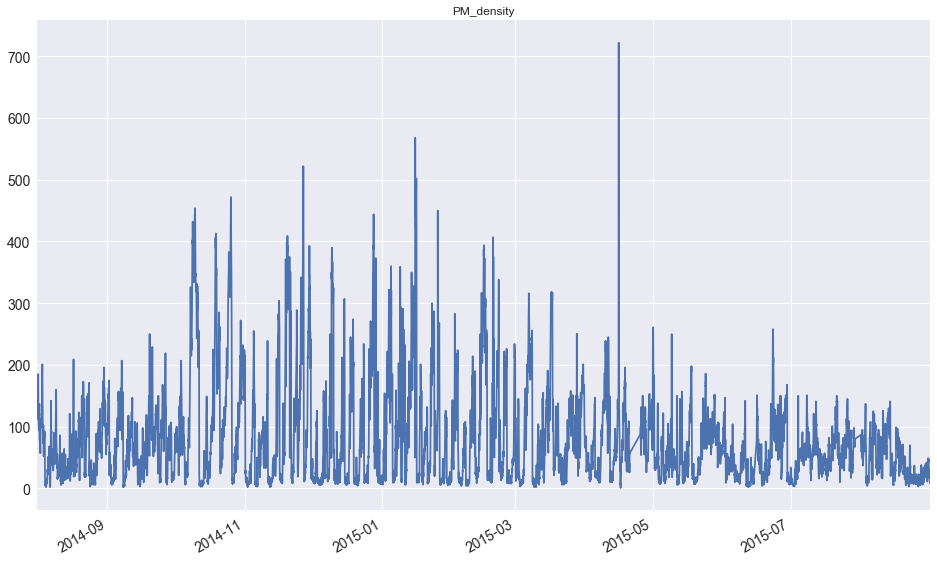

In [126]:
# now we use the data of through Aug. 2014 to Aug. 2015 to build an ARIMA model and make a prediction.
dft_train=dft['2014-8':'2015-8']
dft_train.head(4)
# plot the data again
dft_train.PM_density.plot(figsize=(16,10), title= 'PM_density', fontsize=14)

##### Now we build an ARIMA model. First we determine the parameter d.

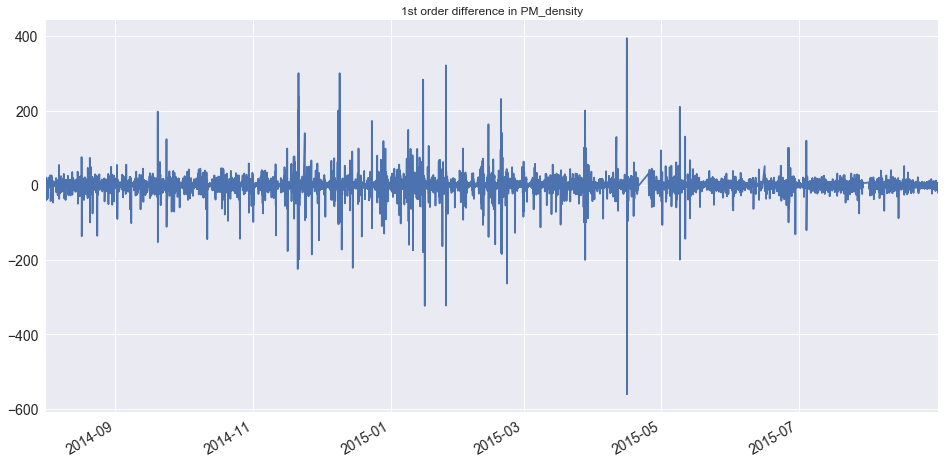

In [127]:
# let d=1
dft_train['PM_d1'] = dft_train['PM_density'].diff(1)
dft_train.PM_d1.plot(figsize=(16,8), title= '1st order difference in PM_density', fontsize=14)
#dft_train[:10]

##### We found the mean and variance of the 1st order differenced values are almost stable. Thus, we can select the p and q value. We first plot the autocorrelation and partial autocorrelation function as follows.

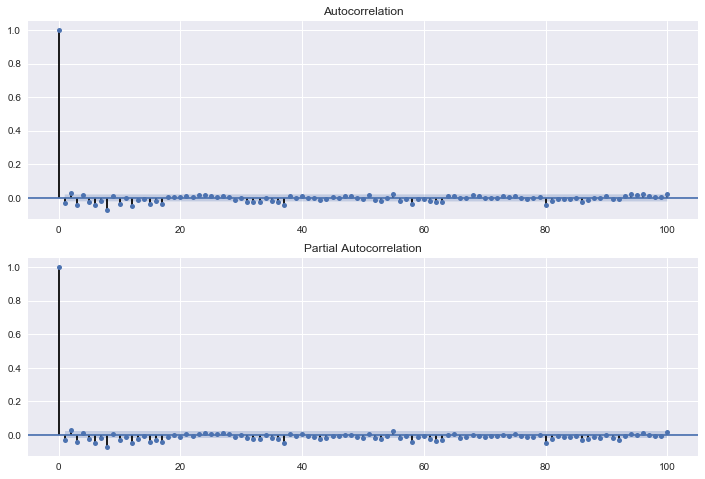

In [141]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dft_train.PM_d1.iloc[1:],lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dft_train.PM_d1.iloc[1:],lags=100, ax=ax2)

##### Here is the rule we used to determine the p and q value: If the ACF shows exponential decay starting at lag 1, and the PACF shows exponential decay starting at lag 1, then use one autoregressive (p) and one moving average (q) parameter. Therefore, we selected p=1 and q=1.

In [154]:
# train an ARIMA model
PM_pred_obj = sm.tsa.ARMA(dft_train.PM_density,(1,1)).fit()

In [155]:
len(dft_train)

9202

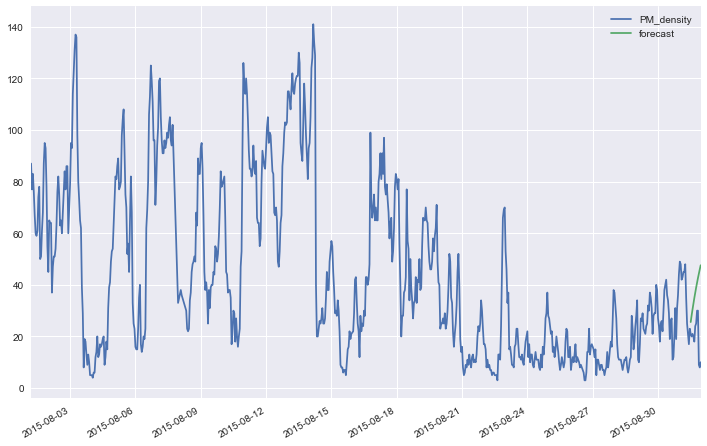

In [165]:
# make the prediction
#dft_train.PM_density
dft_train['forecast'] = PM_pred_obj.predict(start = 9190, end= 9201, dynamic= True) # 12898-14289  
#dft_train
dft_plot = dft_train['2015-8']
#dft_plot
dft_plot[['PM_density', 'forecast']].plot(figsize=(12, 8))

##### Now, let's compute the Mean Forecast Error (MFE) and Mean Absolute Error (MAE)

In [160]:
from sklearn.metrics import mean_absolute_error
new_dat = dft_plot[-12:]
model_MAE=mean_absolute_error(new_dat.PM_density, new_dat.forecast)
print('model_MAE =',model_MAE)

err_sum=0
l=len(new_dat)
for i in range(l):
    err_sum=err_sum+(new_dat.PM_density[i]-new_dat.forecast[i])
model_MFE=err_sum/l
print('model_MFE =',model_MFE)


model_MAE = 17.7607356857
model_MFE = -17.7607356857


##### The high MFE indicates the forcast is overshooting the actual observations a lot. We checked the data in August, 2014 and found that the prediction is similar with those data. After discussion, we suspected there was big event happened that time and the government had reinforced their control effort. We searched online and realized that 2015 is the 70th anniversary of both the world's anti-fascism war and the victory of China's Resistance War against Japanese Aggression this year. Started from Aug. 20th, 2015, Beijing has took some strategies to ensure the good status of air condition for the celebration events. It's observed that the PM2.5 density had obviously reduced.